<a href="https://colab.research.google.com/github/pieter98/question_metadata/blob/main/QM_notebooks/QM01_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing of the data
This notebook is purely focused on the preprocessing of the data.

We will transform the existing data to a format that is usuable for the other notebooks.



#### **!! for GDPR reasons the data used in this notebook is limited to only a few anonymised data samples ¡¡**

## The data

The availlable data is a full export of questions from the *assessmentQ* platform developped by *Televic Education* ([assessmentQ website](https://assessmentq.com/)). 

AssessmentQ is a digital assessment and interactive practice platform which allows it's teachers/lectors to create exams, distribute access to the exams to students, partake in exams, gather useful metrics and reports based on the exam results,... . 

The data was gathered over the past data and consists of exam/test questions created by the users of the platform.

## Format of the data

the most relevant fields in the data structure (JSON):

```
{
  "Id": "...", // question id
  "Type": "...", // FGQ: Fill Gaps Question, MCQ: Multiple Choice Question, OQ: Open Question
  "Name": "...", // question name
  "Instruction": "...", // question instruction (in HTML format)
  ...
  "Answers": [...], // question answers if present (OQ does not have a default answer)
  ...
  "Metadata": { // extra metadata (Added by tools or users)
    "Language": "...", // question language
    "Subject": "...", // question subject (mostly null values or incorrect labelling)
    "Sector": "...", // sector of the client, this field is determined by the creators company
    ...
    "Custom": [...], // custom metadata added by users
    "Location": "..." // location of the question within the assessmentQ filestructure
  }
}
```
Full data examples can be found [here](https://github.com/pieter98/question_metadata/tree/main/data).

## 1. extracting relevant text fields

First and foremost we must determine which fields of the data are useable for determining the qustion topic. To accomplish this we mainly look at the following fields: 

- Name: the question name can contain useful info about the question (e.g. "Math question 1")
- Instruction: this property contains the instruction text of the question (in HTML) -> the main explanation of the question.
- Answers: the answers can provide us with useful insights into the topic (also in HTML format)
- Metadata > Location: The Location metadata contains a textual representation of the folder location within assessmentQ where the question is located (see image).
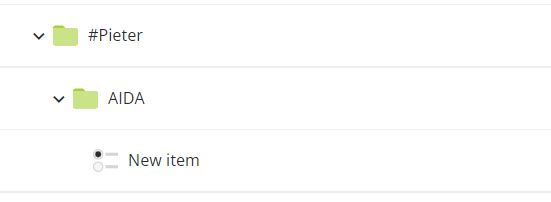
Alot of users use the folder system to indicate the topics of their questions, therefor this data could be very useful (but it depends highly on the user and the user's company).


We'll extract the textual data from all of these fields and add them as new properties to the data JSON. 


**Disclaimer: the preprocessing code is by no means efficient, it is a quick and dirty way to achieve what we needed**


### 1.1. installing and importing necessary libraries

In [1]:
# BeautifulSoup for HTML parsing
!pip install beautifulsoup4
# tqdm for visualising processing progress
!pip install tqdm

In [2]:
import os
import json
from tqdm import tqdm
from bs4 import BeautifulSoup

### 1.2. Data before text extraction
In this part we define a helper method to print out the json data. A quick print of a datapoint before preprocessing is shown.

In [8]:
def print_json_helper(filename):
  file = open(filename, "r")
  file_json = json.load(file)
  pretty_json = json.dumps(file_json, indent=4)
  print(pretty_json)
  file.close()

to quickly check if the datafolder is present we can use the "!ls" command. The data should be added in the "data" folder.

In [6]:
!ls

data  sample_data


Quick test print of a single data file before any preprocessing has been applied

In [17]:
print_json_helper("data/sample.mcq.json")

{
    "Id": "0000FBB0-D511-4151-A468-06F215620C31",
    "Type": "MCQ",
    "Name": null,
    "Instruction": "<p style=\"text-align:justify;font-size:15px;\">Which of these rivers is the longest?</p>",
    "Answers": [
        {
            "Value": "<p>Amazon River</p>",
            "IsCorrect": false,
            "ChoiceId": 0
        },
        {
            "Value": "<p>Danube River</p>",
            "IsCorrect": true,
            "ChoiceId": 1
        },
        {
            "Value": "<p>Nile River</p>",
            "IsCorrect": false,
            "ChoiceId": 2
        },
        {
            "Value": "<p>Hudson River</p>",
            "IsCorrect": false,
            "ChoiceId": 3
        }
    ],
    "Scoring": {
        "MaxScore": 10.0,
        "MinScore": 0.0
    },
    "Metadata": {
        "Language": "eng",
        "Subject": null,
        "Sector": "Secondary Education",
        "Difficulty": null,
        "CustomerId": null,
        "Custom": [],
        "Location": "Con

### 1.3. Textual data extraction method
The following method is a slightly edited version of the one that can be found [here](https://github.com/pieter98/question_metadata/blob/main/pre_processing_methods/language_extractor.py). The method takes the data directory path as input and iterates over all files within this directory

In [30]:
'''
===================================================================================================================
METHOD: (extract_textual_data)
as the name suggests this method extracts the textual data from the assessmentQ question data
PARAMS:
dir_path: path to directory containing the questions you want to process
dest_path: path to directory where the processed data needs to be stored
===================================================================================================================
'''

def extract_textual_data(dir_path, dest_path):
    if os.path.isdir(dir_path):

        # go over all files in the directory
        for file_name in tqdm(os.listdir(dir_path)):
            if file_name != '.ipynb_checkpoints':
                file_path = os.path.join(dir_path, file_name)
                file = open(file_path)
                json_file = json.load(file)

                # Extract & clean textual data from "Metadata" > "Location"
                json_file["Location_Cleaned"] = json_file["Metadata"]["Location"].replace('>', ' ')
                # Extract & clean textual data from "Instruction"
                json_file["Instruction_Cleaned"] = BeautifulSoup(json_file['Instruction'], 'html.parser').text
                # Extract & clean textual if there is an "Anwsers" property present
                if 'Answers' in json_file:
                    json_file["Answers_Cleaned"] = ""
                    for i in json_file['Answers']:
                        if "Value" in i and i["Value"] is not None:
                            json_file["Answers_Cleaned"] += BeautifulSoup(i['Value'], 'html.parser').text + '\n'
                        if "Text" in i and i["Text"] is not None:
                            json_file["Textual_data"] += BeautifulSoup(i['Text'], 'html.parser').text + '\n'
      
                # save the data
                dest_file_path = os.path.join(dest_path, file_name)
                with open(dest_file_path, "w") as file:
                    json.dump(json_file, file)

We'll 

In [31]:
extract_textual_data("data","data_text_extracted")

100%|██████████| 2/2 [00:00<00:00, 649.17it/s]


In [32]:
print_json_helper("data_text_extracted/sample.mcq.json")

{
    "Id": "0000FBB0-D511-4151-A468-06F215620C31",
    "Type": "MCQ",
    "Name": null,
    "Instruction": "<p style=\"text-align:justify;font-size:15px;\">Which of these rivers is the longest?</p>",
    "Answers": [
        {
            "Value": "<p>Amazon River</p>",
            "IsCorrect": false,
            "ChoiceId": 0
        },
        {
            "Value": "<p>Danube River</p>",
            "IsCorrect": true,
            "ChoiceId": 1
        },
        {
            "Value": "<p>Nile River</p>",
            "IsCorrect": false,
            "ChoiceId": 2
        },
        {
            "Value": "<p>Hudson River</p>",
            "IsCorrect": false,
            "ChoiceId": 3
        }
    ],
    "Scoring": {
        "MaxScore": 10.0,
        "MinScore": 0.0
    },
    "Metadata": {
        "Language": "eng",
        "Subject": null,
        "Sector": "Secondary Education",
        "Difficulty": null,
        "CustomerId": null,
        "Custom": [],
        "Location": "Con

## 2. Determine correct language
As previously mentioned there is a "Language" property present in the data. However during previous research projects it has come to light that this language indication is often incorrect. The language detection tool which was originally used for determining the language of the questions, was not accurate enough (e.g. "dutch" was often misinterpreted as "south-african"). Therefor we will now correct this by using some availlable toolboxes.

### 2.1. installing and importing necessary libraries

In [33]:
!pip install googletrans==3.1.0a0

     |████████████████████████████████| 55 kB 3.7 MB/s 
     |████████████████████████████████| 1.3 MB 45.1 MB/s 
     |████████████████████████████████| 42 kB 1.6 MB/s 
     |████████████████████████████████| 65 kB 4.3 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16367 sha256=4b246e55541d3f2105293c9d0b82fc24da6ee2f7dc0198455210fb8593e66c92
  Stored in directory: /root/.cache/pip/wheels/0c/be/fe/93a6a40ffe386e16089e44dad9018ebab9dc4cb9eb7eab65ae
Successfully built googletrans


In [47]:
from googletrans import Translator
from tqdm import tqdm

### 2.2. Language extraction method
The following method is a modified version of the method that can be found [here](https://github.com/pieter98/question_metadata/blob/main/pre_processing_methods/language_extractor.py).

In [48]:
'''
===================================================================================================================
METHOD: (extract_language)
as the name suggests this method derrives the language from the textual data in the assessmentQ question
PARAMS:
dir_path:   path to directory containing the questions you want to process
dest_path:  path to directory where the processed data needs to be stored
===================================================================================================================
'''

def extract_language(dir_path, dest_path):
    translator = Translator()
    if os.path.isdir(dir_path):

        # iterate over all files in the directory
        for file_name in tqdm(os.listdir(dir_path)):
            if file_name != '.ipynb_checkpoints':
                file_path = os.path.join(dir_path, file_name)
                file = open(file_path)
                json_file = json.load(file)

                # create a voting dictionary
                voting_dict = {}

                # determine the language for all textual data parts we extracted, each part prediction is a vote for a certain language
                if json_file["Instruction_Cleaned"] != "":
                    pred = translator.detect(json_file["Instruction_Cleaned"]).lang
                    if pred in voting_dict:
                        voting_dict[pred] += 1
                    else:
                        voting_dict[pred] = 1
                if json_file["Answers_Cleaned"] != "":
                    pred = translator.detect(json_file["Answers_Cleaned"]).lang
                    if pred in voting_dict:
                        voting_dict[pred] += 1
                    else:
                        voting_dict[pred] = 1
                if json_file["Location_Cleaned"] != "":
                    pred = translator.detect(json_file["Location_Cleaned"]).lang
                    if pred in voting_dict:
                        voting_dict[pred] += 1
                    else:
                        voting_dict[pred] = 1

                # Language with the highest number of votes will be used
                if len(voting_dict) !=0:
                    json_file["Language_Extracted"] = max(voting_dict, key=voting_dict.get)
                else: 
                    json_file["Language_Extracted"] = null

                # save to dest directory
                dest_file_path = os.path.join(dest_path, file_name)
                with open(dest_file_path, "w") as file:
                    json.dump(json_file, file)

We'll run the method on all files that were already processed by the textual data extractor

In [49]:
extract_language("data_text_extracted","data_language_extracted")

100%|██████████| 2/2 [00:00<00:00,  6.76it/s]


In [50]:
print_json_helper("data_language_extracted/sample.mcq.json")

{
    "Id": "0000FBB0-D511-4151-A468-06F215620C31",
    "Type": "MCQ",
    "Name": null,
    "Instruction": "<p style=\"text-align:justify;font-size:15px;\">Which of these rivers is the longest?</p>",
    "Answers": [
        {
            "Value": "<p>Amazon River</p>",
            "IsCorrect": false,
            "ChoiceId": 0
        },
        {
            "Value": "<p>Danube River</p>",
            "IsCorrect": true,
            "ChoiceId": 1
        },
        {
            "Value": "<p>Nile River</p>",
            "IsCorrect": false,
            "ChoiceId": 2
        },
        {
            "Value": "<p>Hudson River</p>",
            "IsCorrect": false,
            "ChoiceId": 3
        }
    ],
    "Scoring": {
        "MaxScore": 10.0,
        "MinScore": 0.0
    },
    "Metadata": {
        "Language": "eng",
        "Subject": null,
        "Sector": "Secondary Education",
        "Difficulty": null,
        "CustomerId": null,
        "Custom": [],
        "Location": "Con

## 3. Data to csv
We can now split the data by using the different properties that we added/were already present. 

- Splitting on sector
- Splitting on language
- Differentiation of datasets by which text fields are incorporated.
- ...

We will define a method where which takes a list of options. Based on these options it will generate a .csv file containing all data.

### 3.1. importing necessary libraries

In [51]:
import csv

### 3.2 defining the method

In [76]:
'''
===================================================================================================================
METHOD: (data_to_csv)
as the name suggests this method will filter the data based on the provided parameters and write the 
resulting data to a csv file
PARAMS:
dir_path:               path to directory containing the questions you want to process
dest_path:              path to directory where the processed data needs to be stored
sector:                 desired sector of the data
languague:              desired language of the data
textual_data_options:   extra options for the textual data
          * answers:    the answer data will be included
          * location:   the location data will be included
===================================================================================================================
'''

def data_to_csv(dir_path, dest_path, sector, language, textual_data_options=None):
    if os.path.isdir(dir_path):

        # creation of csv file with naming convention based on parameters
        csv_file_name = "{}_{}".format(language, sector.lower().replace(" ", "_"))
        if textual_data_options: 
          for option in textual_data_options: csv_file_name += "_{}".format(option)
        csv_file_name += ".csv"
        csv_file_path = os.path.join(dest_path, csv_file_name)
        csv_file = open(csv_file_path, "w")
        csv_writer = csv.writer(csv_file)

        # iterate over all files in the directory
        for file_name in tqdm(os.listdir(dir_path)):
            if file_name != '.ipynb_checkpoints':
                file_path = os.path.join(dir_path, file_name)
                file = open(file_path)
                json_file = json.load(file)
                
                if sector == json_file["Metadata"]["Sector"] and language == json_file["Language_Extracted"]:
                    row_data = [json_file["Id"]]
                    textual_data = json_file["Instruction_Cleaned"]
                    if textual_data_options:
                        if "answers" in textual_data_options:
                            textual_data += "\n{}".format(json_file["Answers_Cleaned"])
                        if "location" in textual_data_options:
                            textual_data += "\n{}".format(json_file["Location_Cleaned"])
                    row_data.append(textual_data)
                    csv_writer.writerow(row_data)


We'll run the method on the preprocessed data (only one sample file here).

First with no extra textual_data_options:

In [78]:
data_to_csv("data_language_extracted", "test", "Secondary Education", "en")

100%|██████████| 1/1 [00:00<00:00, 1716.16it/s]


with extra textual data options:

In [79]:
data_to_csv("data_language_extracted", "test", "Secondary Education", "en", textual_data_options=["answers", "location"])

100%|██████████| 1/1 [00:00<00:00, 1300.16it/s]


The resulting csv files can be found in the destination folder (if this parameter was not changed this will be the "test" folder)

## Conclusion

this notebook briefly illustrated the preprocessing steps which needed to be taken to tranform the raw assessmentQ data into a usuable form and filter the data based on sector and language.

